In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error



In [ ]:
df = pd.read_csv('GAS.CMDUSD_Candlestick_1_D_BID.csv')
df2 = pd.read_csv('INDPRO (1).csv')
df1 = pd.read_csv('CPIAUCSL.csv')


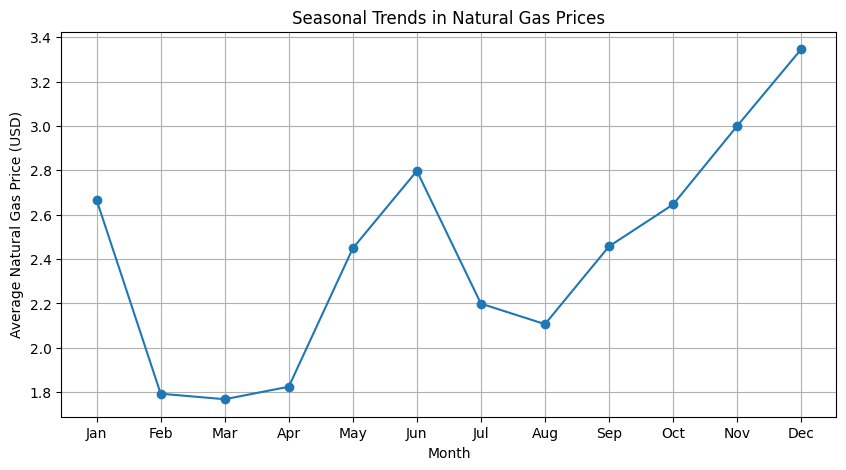

In [ ]:
# Convert the date column to datetime format
df.columns = ["Local Time", "Open", "High", "Low", "Close", "Volume"]
df["Date"] = pd.to_datetime(df["Local Time"].astype(str).str[:10], format="%d.%m.%Y", errors='coerce')
df.drop(columns=["Local Time"], inplace=True)

# Extract the month and year
df["Month"] = df["Date"].dt.month
df["Year"] = df["Date"].dt.year

# Group by month and calculate average prices
seasonal_trends = df.groupby("Month")["Close"].mean()


# Plot seasonal trends
plt.figure(figsize=(10, 5))
plt.plot(seasonal_trends.index, seasonal_trends.values, marker='o', linestyle='-')
plt.xlabel("Month")
plt.ylabel("Average Natural Gas Price (USD)")
plt.title("Seasonal Trends in Natural Gas Prices")
plt.xticks(range(1, 13), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.grid()
plt.show()



**Seasonal effects:**

Gas price rise in the winter period, which can be explained by an increase in the need for gas for heating. The price comes down in spring because of the good weather.
In summer there's a moderate price rise, most logically for air-conditioning equipment, and finally in autumn there's a transition period when the price increases to reach winter levels.

In [ ]:
df = pd.read_csv('GAS.CMDUSD_Candlestick_1_D_BID.csv')
df2 = pd.read_csv('INDPRO (1).csv')
df1 = pd.read_csv('CPIAUCSL.csv')

# Convert date columns to datetime format
df.columns = ["Local Time", "Open", "High", "Low", "Close", "Volume"]
df["Date"] = pd.to_datetime(df["Local Time"].astype(str).str[:10], format="%d.%m.%Y", errors='coerce')
df.drop(columns=["Local Time"], inplace=True)

df1.columns = ["Date", "CPI"]
df1["Date"] = pd.to_datetime(df1["Date"], errors='coerce')

df2.columns = ["Date", "IPI"]
df2["Date"] = pd.to_datetime(df2["Date"], errors='coerce')

# Ensure CPI and IPI are at monthly level while gas price is daily
df1.set_index("Date", inplace=True)
df2.set_index("Date", inplace=True)

df1 = df1.resample('D').ffill().reset_index()
df2 = df2.resample('D').ffill().reset_index()

# Merge datasets
df = df.merge(df1, on="Date", how="left").merge(df2, on="Date", how="left")
df.fillna(method='ffill', inplace=True)

# Reorder columns to ensure Date is the first column
column_order = ["Date", "Close", "CPI", "IPI"]
df = df[column_order]
print(df)

          Date   Close      CPI       IPI
0   2023-12-31  2.4931  308.742  102.6309
1   2024-01-01  2.5677  309.685  101.4830
2   2024-01-02  2.6810  309.685  101.4830
3   2024-01-03  2.8419  309.685  101.4830
4   2024-01-04  2.8989  309.685  101.4830
..         ...     ...      ...       ...
362 2024-12-27  3.4050  317.685  103.1942
363 2024-12-28  3.4050  317.685  103.1942
364 2024-12-29  3.9099  317.685  103.1942
365 2024-12-30  3.6310  317.685  103.1942
366 2024-12-31  3.6310  317.685  103.1942

[367 rows x 4 columns]


<ipython-input-13-ac9feef81886>:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


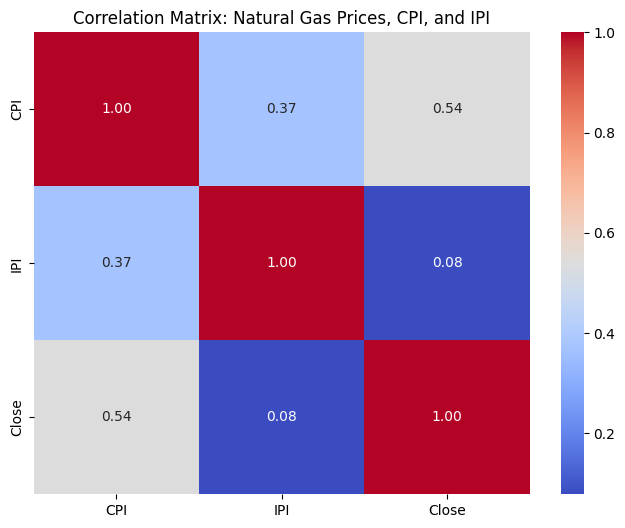

In [ ]:
correlation_data = pd.DataFrame({
    "CPI": df["CPI"],
    "IPI": df["IPI"],
    "Close": df["Close"]
})
correlation_matrix = correlation_data.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix: Natural Gas Prices, CPI, and IPI")
plt.show()

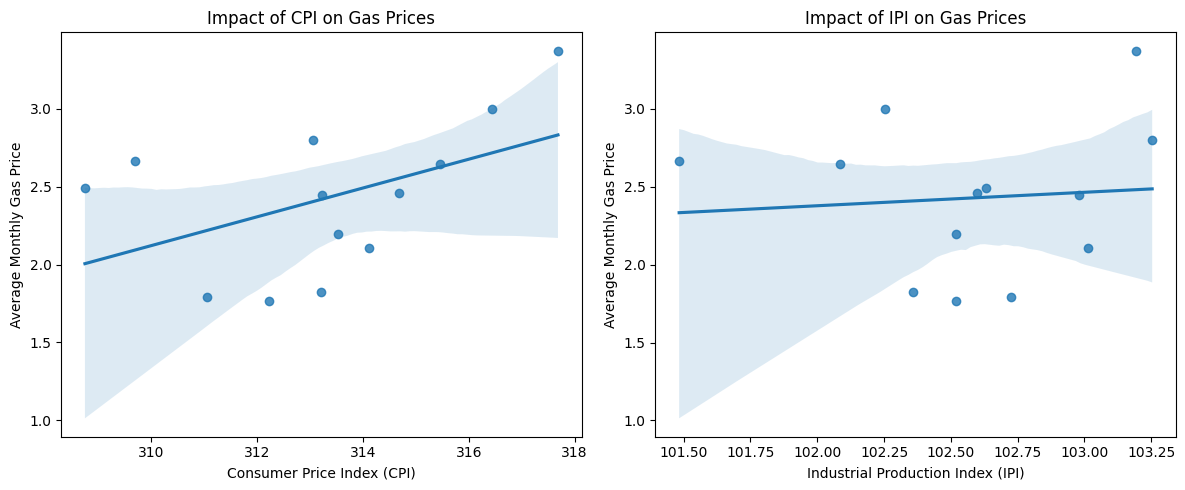

In [ ]:
# Aggregate data to monthly level
df["Year-Month"] = df["Date"].dt.to_period("M")
monthly_df = df.groupby("Year-Month")[["Close", "CPI", "IPI"]].mean().reset_index()

# Scatter plots with regression lines
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.regplot(x=monthly_df["CPI"], y=monthly_df["Close"])
plt.xlabel("Consumer Price Index (CPI)")
plt.ylabel("Average Monthly Gas Price")
plt.title("Impact of CPI on Gas Prices")

plt.subplot(1, 2, 2)
sns.regplot(x=monthly_df["IPI"], y=monthly_df["Close"])
plt.xlabel("Industrial Production Index (IPI)")
plt.ylabel("Average Monthly Gas Price")
plt.title("Impact of IPI on Gas Prices")

plt.tight_layout()
plt.show()

In [ ]:
# Create lag features for past gas prices
df["Close_Lag1"] = df["Close"].shift(1)
df["Close_Lag2"] = df["Close"].shift(2)
df["Close_Lag3"] = df["Close"].shift(3)
df["Close_Lag4"] = df["Close"].shift(4)
#df["Close_Lag7"] = df["Close"].shift(7)
#df["Close_Lag11"] = df["Close"].shift(11)
#df["Close_Lag30"] = df["Close"].shift(30)

# Drop NaN values after introducing lag features
df.dropna(inplace=True)
tf.config.run_functions_eagerly(True)
# Feature Selection
features = ["CPI", "IPI", "Close_Lag1", "Close_Lag2","Close_Lag3","Close_Lag4"]
target = "Close"

# Prepare data for modeling
X = df[features]
y = df[target]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape input for LSTM (samples, time steps, features)
X_train_scaled = tf.convert_to_tensor(X_train_scaled, dtype=tf.float32)
X_train_scaled = tf.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = tf.convert_to_tensor(X_test_scaled, dtype=tf.float32)
X_test_scaled = tf.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Reshape target variable for LSTM
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_train = tf.reshape(y_train, (-1, 1))
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)
y_test = tf.reshape(y_test, (-1, 1))

# Build LSTM Model
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(1, X_train_scaled.shape[2])),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)
])

# Compile Model
model.compile(optimizer='adam', loss='mse')

# Train Model
model.fit(X_train_scaled, y_train, epochs=50, batch_size=16, validation_data=(X_test_scaled, y_test), verbose=1)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Model Evaluation
mae = mean_absolute_error(y_test.numpy(), y_pred)
mse = mean_squared_error(y_test.numpy(), y_pred)

rmse = np.sqrt(mse)

# Display results
model_performance = pd.DataFrame({
    "Metric": ["Mean Absolute Error (MAE)", "Mean Squared Error (MSE)", "Root Mean Squared Error (RMSE)"],
    "Value": [mae, mse, rmse]
})
print(model_performance)

# Forecasting Function
def predict_gas_price(future_cpi, future_ipi, past_prices):
    past_prices = np.array(past_prices).reshape(1, -1)
    future_features = np.array([[future_cpi, future_ipi, *past_prices[0]]])
    scaled_input = scaler.transform(future_features).reshape(1, 1, -1)
    return model.predict(scaled_input)[0][0]

# Example Usage
future_cpi = 317.685
future_ipi = 103.1942
past_prices = [3.3612,3.2217,3.2637,3.2637 ]  # Example of past 1-day, 2-day, 3-day and 4-day closing prices
predicted_price = predict_gas_price(future_cpi, future_ipi, past_prices)
print(f"Predicted Natural Gas Price: {predicted_price:.2f} USD")



Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 158ms/step - loss: 5.0946 - val_loss: 8.4678
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - loss: 4.2306 - val_loss: 5.4221
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - loss: 2.5982 - val_loss: 1.3834
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - loss: 0.7240 - val_loss: 16.5918
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - loss: 0.4240 - val_loss: 7.2169
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - loss: 0.2769 - val_loss: 7.8922
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - loss: 0.1621 - val_loss: 6.0431
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - loss: 0.1197 - val_loss: 4.1616
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - loss: 0.1198 - val_loss: 2.6931
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - loss: 0.0927 - val_loss: 2.5901
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - loss: 0.0866 - val_loss: 2.1584
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - loss: 0

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


**We obtain 3.30 for the predicted value or the observed value is 3.36, not very bad, but we need to test the predictive performance of our model in more values to be more confident about it. We can improve the model by the chosing the optimal hyperparametrs and the right lags to put in the LSTM**

Feature Sensitivity Summary:
      Feature  Sensitivity
2  Close_Lag1     0.235882
3  Close_Lag2     0.074439
0         CPI     0.066827
1         IPI     0.050670
5  Close_Lag4     0.038782
4  Close_Lag3     0.023878


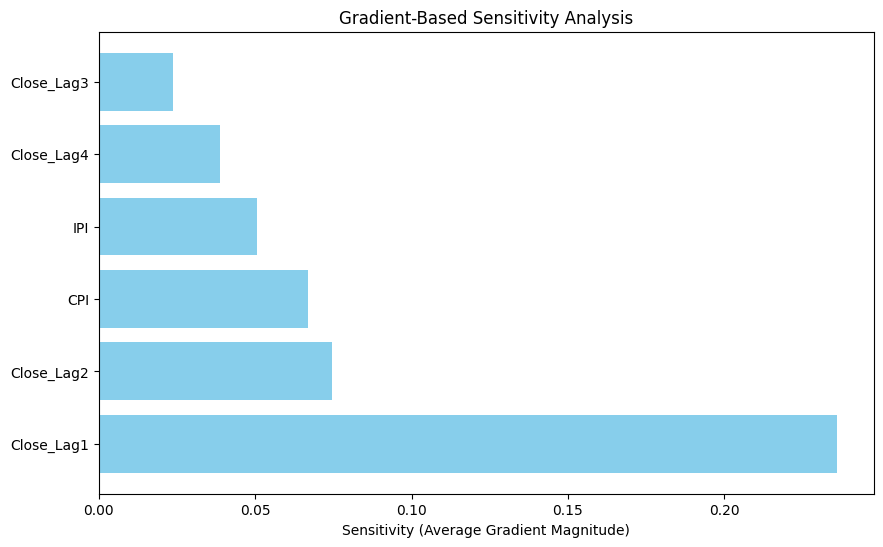

In [ ]:
# Gradient-based sensitivity analysis
def compute_gradients(model, X):
    """
    Compute gradients of the model's output with respect to its inputs.
    """
    X_tensor = tf.convert_to_tensor(X, dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(X_tensor)
        predictions = model(X_tensor)
    gradients = tape.gradient(predictions, X_tensor)
    return gradients.numpy()
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = X_train_scaled.reshape((X_train.shape[0], 1, X_train.shape[1]))

# Compute gradients for the training data
gradients = compute_gradients(model, X_train_scaled)

# Aggregate gradient magnitudes (absolute values) across the dataset
feature_sensitivity = np.mean(np.abs(gradients), axis=0)

# Summarize sensitivity for each feature
feature_names = ["CPI", "IPI", "Close_Lag1","Close_Lag2","Close_Lag3","Close_Lag4"] # Replace with actual feature names
sensitivity_summary = pd.DataFrame({
    'Feature': feature_names,
    'Sensitivity': feature_sensitivity.mean(axis=0)  # Average across time steps
})

# Sort by sensitivity
sensitivity_summary = sensitivity_summary.sort_values(by='Sensitivity', ascending=False)

# Print results
print("Feature Sensitivity Summary:")
print(sensitivity_summary)

# Visualize results
plt.figure(figsize=(10, 6))
plt.barh(sensitivity_summary['Feature'], sensitivity_summary['Sensitivity'], color='skyblue')
plt.xlabel('Sensitivity (Average Gradient Magnitude)')
plt.title('Gradient-Based Sensitivity Analysis')
plt.show()



In [ ]:
from sklearn.model_selection import  KFold
i


# Create lag features for past gas prices
df["Close_Lag1"] = df["Close"].shift(1)
df["Close_Lag2"] = df["Close"].shift(2)
df["Close_Lag3"] = df["Close"].shift(3)
df["Close_Lag4"] = df["Close"].shift(4)
#df["Close_Lag7"] = df["Close"].shift(7)
#df["Close_Lag11"] = df["Close"].shift(11)
#df["Close_Lag30"] = df["Close"].shift(30)

# Drop NaN values after introducing lag features
df.dropna(inplace=True)

# Feature Selection
# Feature Selection
features = ["CPI", "IPI", "Close_Lag1", "Close_Lag2","Close_Lag3","Close_Lag4"]
target = "Close"

# Prepare data for modeling
X = df[features]
y = df[target]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape input for LSTM (samples, time steps, features)
X_scaled = tf.convert_to_tensor(X_scaled, dtype=tf.float32)
X_scaled = tf.reshape(X_scaled, (X_scaled.shape[0], 1, X_scaled.shape[1]))
y = tf.convert_to_tensor(y, dtype=tf.float32)
y = tf.reshape(y, (-1, 1))

# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

for train_index, test_index in kf.split(X_scaled):
    X_train, X_test = X_scaled.numpy()[train_index], X_scaled.numpy()[test_index]
    y_train, y_test = y.numpy()[train_index], y.numpy()[test_index]

    # Build LSTM Model
    model = Sequential([
        LSTM(50, activation='relu', return_sequences=True, input_shape=(1, X_train.shape[2])),
        Dropout(0.2),
        LSTM(50, activation='relu'),
        Dropout(0.2),
        Dense(25, activation='relu'),
        Dense(1)
    ])

    # Compile Model
    model.compile(optimizer='adam', loss='mse')

    # Train Model
    model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)

    # Make predictions
    y_pred = model.predict(X_test)

    # Model Evaluation
    mse = mean_squared_error(y_test, y_pred)
    cv_scores.append(mse)

# Display cross-validation results
cv_results = pd.DataFrame({"Fold": range(1, 6), "MSE": cv_scores})
print(cv_results)
print(f"Average MSE: {np.mean(cv_scores):.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
   Fold       MSE
0     1  0.010639
1     2  0.014102
2     3  0.025672
3     4  0.010230
4     5  0.012909
Average MSE: 0.0147


##**Follow up Questions**##

**Question 1:** How would you handle missing or unreliable data in your analysis?


**Answer:**

Handling missing or unreliable data is a frequent challenge in commodity trading analysis. Here’s my approach:

**Identify Missing Data:**
I would utilize Python libraries such as Pandas to find missing values (using isnull() and info()).

**Imputation Techniques:**
For time-series data, like natural gas prices, I would apply interpolation methods, such as linear interpolation (using pandas.interpolate()) or time-based forward/backward filling.
For macroeconomic indicators, such as IPI and CPI, I would consider statistical methods like mean or median imputation, or even regression-based imputation.
For seasonal data, I would look into seasonal decomposition and impute based on historical seasonal patterns.

**Remove Unreliable Data:**
In cases where data is unreliable, such as outliers or errors, I would either remove or correct it using domain knowledge or statistical techniques like Z-scores or the Interquartile Range (IQR).


**Question 2:** What are the main risks involved in pricing natural gas contracts based on historical trends?


**Answer:**

The main risks of pricing natural gas contracts based on historical trends include:

**Market Volatility:**
Natural gas prices can be extremely volatile, influenced by geopolitical events, weather fluctuations, and supply-demand imbalances. Historical trends might not account for sudden market changes.

**Non-Stationarity:**
The time-series data for natural gas prices may not be stationary, meaning that the mean and variance can change over time, which makes historical trends less dependable for future forecasts.

**Macroeconomic Shocks:**
Unexpected macroeconomic events, such as recessions or policy shifts, can disrupt established historical patterns.


**Model Overfitting:**
Placing too much reliance on historical data can lead to overfitting, where the model performs well on past data but poorly on new data.

**Question 3:** How would you adapt your model to incorporate real-time market changes?


**Answer:**

To adapt my model for real-time market changes, I would take the following steps:

**Utilize Real-Time Data Feeds:**
Integrate APIs or data streams to obtain real-time natural gas prices and relevant macroeconomic indicators.

**Dynamic Model Updating:**
Adopt an online learning approach that allows the model to update its parameters as new data becomes available, using methods like stochastic gradient descent or rolling window retraining.

